In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import numpy as np

In [4]:
from bins import Hist, Bin

In [5]:
from collections import Counter

In [6]:
import matplotlib.pyplot as plt

#### Import histograms from input files

In [7]:
histogram_21l = Hist('data/largedrum_21L_dense_MedianCut_3cmVoxel_all.discriminator.root')
histogram_bitumen = Hist(infile='data/largedrum_onlybitumen_dense_newmetrics_3cmVoxel_April2021.discriminator.root')
histogram_hydrogen = Hist(infile='data/largedrum_onlyhydrogen_dense_newmetrics_3cmVoxel_April2021.discriminator.root')

In [8]:
histogram_21l_shifted= Hist('data/largedrum_21L_5cm_dense_newmetrics_3cmVoxel_April2021.discriminator.root')

#### Cylindrical selection

In [9]:
drum_21l =  histogram_21l.cylinder_select(threshold=290, edges_x=Bin(-400,400))
drum_bitumen = histogram_bitumen.cylinder_select(threshold=290, edges_x=Bin(-400,400))
drum_hydrogen = histogram_hydrogen.cylinder_select(threshold=290, edges_x=Bin(-400,400))
drum_21l_hydr = histogram_21l.cylinder_select(threshold=90, edges_x=Bin(-90,90))
drum_21l_hydr_shifted = histogram_21l_shifted.cylinder_select(threshold=90, edges_x=Bin(-120,60))

Define distance bins: 12 bins between 15 and 300

In [10]:
bins = np.linspace(15, 300, 20)

Define bin edges, as Bin(left, right) for each bin

In [11]:
bin_edges = np.asarray([Bin(l, r) for l, r in zip(bins[:-1], bins[1:])])

In [12]:
bin_edges

array([Bin(left=15.0, right=30.0), Bin(left=30.0, right=45.0),
       Bin(left=45.0, right=60.0), Bin(left=60.0, right=75.0),
       Bin(left=75.0, right=90.0), Bin(left=90.0, right=105.0),
       Bin(left=105.0, right=120.0), Bin(left=120.0, right=135.0),
       Bin(left=135.0, right=150.0), Bin(left=150.0, right=165.0),
       Bin(left=165.0, right=180.0), Bin(left=180.0, right=195.0),
       Bin(left=195.0, right=210.0), Bin(left=210.0, right=225.0),
       Bin(left=225.0, right=240.0), Bin(left=240.0, right=255.0),
       Bin(left=255.0, right=270.0), Bin(left=270.0, right=285.0),
       Bin(left=285.0, right=300.0)], dtype=object)

Thresholds array (evaluated in a different notebook

In [13]:
ts = np.array([11.37237 , 11.383484, 11.362829, 11.411325, 11.361368, 11.409951,
       11.354243, 11.430184, 11.356508, 11.453635, 11.330235, 11.468952,
       11.335208, 11.513633, 11.339232, 11.500191, 11.134762, 11.437215,
       11.275888])

ts = np.array([11.379779 , 11.382227 , 11.361368 , 11.397569 , 11.4029045,
       11.387936 , 11.375538 , 11.429283 , 11.440058 , 11.37425  ,
       11.216588 , 11.47209  ], dtype=np.float32)

ts = np.array([11.37237 , 11.383484, 11.35881 , 11.388082, 11.361368, 11.381344,
       11.387841, 11.394067, 11.406638, 11.351276])

Define ground truth for bubble and put nonzero values to 1

In [14]:
map_bubble = drum_21l_hydr.padded_histogram

In [15]:
gt_bubble = np.zeros_like(map_bubble)

In [16]:
gt_bubble[map_bubble>0] = 1

Define bin_map: same for each histogram of the same size (using padded histograms - same size as original)

In [17]:
bin_map =np.digitize(histogram_21l.distance_axis(axis=0).distance, bins=bins[:-1])-1

In [18]:
Counter(bin_map)

Counter({18: 125400,
         17: 1848,
         16: 1716,
         15: 1848,
         14: 1980,
         13: 1056,
         12: 1452,
         11: 1320,
         10: 924,
         9: 1056,
         8: 1188,
         7: 792,
         6: 660,
         5: 792,
         4: 660,
         2: 396,
         3: 264,
         1: 264,
         0: 132})

In [19]:
ts.shape

(19,)

In [20]:
from sklearn.metrics import matthews_corrcoef

Calculate efficiency using hist and gt

In [21]:
bmap_3d = bin_map.reshape(66,66,33)

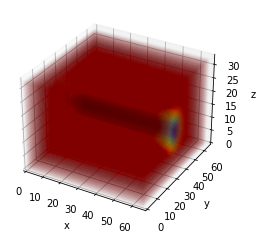

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
xx, yy, zz = np.where(bmap_3d>=0)
pnt3d = ax.scatter(xx, yy, zz, c=bmap_3d, cmap='jet', s=10, alpha=.02)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.axes.set_xlim3d(left=0, right=bmap_3d.shape[0])
ax.axes.set_ylim3d(bottom=0, top=bmap_3d.shape[1])
ax.axes.set_zlim3d(bottom=0, top=bmap_3d.shape[2])
plt.show()

In [68]:
def efficiency(gt_map, hist, ts, bin_map, return_hmap: bool = False):
    est_thresholds = ts[bin_map]
    metric_values = hist.ravel()
    lh = len(hist.ravel())
    
    h_map = (metric_values>=est_thresholds).astype(int)

    gt_map = gt_map.ravel()
    B = len(ts)
    eg = matthews_corrcoef(gt_map, h_map)
    bin_eff = np.zeros(B)
    for i in range(B):
        if np.all(gt_map[bin_map==i])==1:
            gt_map[bin_map==i].append(0)
            h_map[bin_map==i].append(0)
            print(gt_map[bin_map==i], h_map[bin_map==i])
        bin_eff[i] = matthews_corrcoef(gt_map[bin_map==i], h_map[bin_map==i])
    
    if return_hmap:
        return eg, bin_eff, h_map
    return eg, bin_eff

In [69]:
import warnings
warnings.filterwarnings('ignore')

In [70]:
eff, eff_bubble = efficiency(gt_bubble, map_bubble, ts, bin_map)

In [71]:
eff

0.9640622286466835

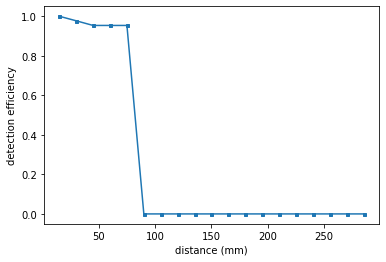

In [72]:
plt.figure()
plt.plot(bins[:-1], eff_bubble,'o-', marker='s', markersize=3)
plt.xlabel('distance (mm)')
plt.ylabel('detection efficiency')
plt.show()

In [73]:
eff_bubble

array([1.        , 0.97691189, 0.95346259, 0.95346259, 0.95346259,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

In [74]:
Lb = Counter(bin_map)

In [75]:
Lb

Counter({18: 125400,
         17: 1848,
         16: 1716,
         15: 1848,
         14: 1980,
         13: 1056,
         12: 1452,
         11: 1320,
         10: 924,
         9: 1056,
         8: 1188,
         7: 792,
         6: 660,
         5: 792,
         4: 660,
         2: 396,
         3: 264,
         1: 264,
         0: 132})

In [76]:
np.sum(efficiency(gt_bubble, map_bubble, ts, bin_map))

array([1.96406223, 1.94097412, 1.91752482, 1.91752482, 1.91752482,
       0.96406223, 0.96406223, 0.96406223, 0.96406223, 0.96406223,
       0.96406223, 0.96406223, 0.96406223, 0.96406223, 0.96406223,
       0.96406223, 0.96406223, 0.96406223, 0.96406223])

#### Same for 8 bubbles

In [77]:
histogram_8blocks =Hist('data/largedrum_0.5L_8Cubes_dense_newmetrics_3cmVoxel_April2021.discriminator.root')

In [1]:
cube_centre_positions = [[130,20,0],[-150,10,0],[20,150,0],[10,-160,0],[140,-130,0],[-120,-120,0],[-110,110,0]]

In [2]:
cube_size=[80,80,80]

In [80]:
cube_edges = [[Bin(i-40, i+40),Bin(j-40,j+40), Bin(k-40,k+40)] for i, j, k in cube_centre_positions]

In [81]:
cubes_hist = [histogram_8blocks.cube_select(edge_cut=sel) for sel in cube_edges]

In [82]:
cubes = [cube.padded_histogram for cube in cubes_hist]

In [83]:
from operator import add
from functools import reduce

In [84]:
cubes_hist = reduce(add,cubes)

In [85]:
gt_bubble_cubes_hist = np.zeros_like(cubes_hist)

In [86]:
gt_bubble_cubes_hist[cubes_hist>0] = 1
gt_bubble_cubes_hist[gt_bubble_cubes_hist>1] = 1
gt_bubble_cubes_hist[gt_bubble_cubes_hist<0] = 0

In [87]:
eff_8b, eff_bubble_8b, hmap = efficiency(gt_bubble_cubes_hist, histogram_8blocks.histogram, 
                                         ts, bin_map, return_hmap=True)

In [88]:
eff_8b

-0.006165242264541819

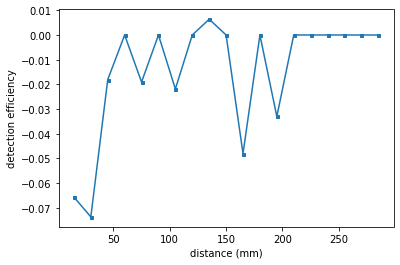

In [89]:
plt.figure()
plt.plot(bins[:-1], eff_bubble_8b, 'o-', marker='s', markersize=3)
plt.xlabel('distance (mm)')
plt.ylabel('detection efficiency')
plt.show()

In [90]:
eff_bubble_8b

array([-0.06565322, -0.07369095, -0.01809677,  0.        , -0.01906579,
        0.        , -0.0218687 ,  0.        ,  0.00637713,  0.        ,
       -0.04804988,  0.        , -0.03301319,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ])

In [91]:
gt_5 = gt_bubble_cubes_hist.ravel()[bin_map==5]
g_zeros = gt_5[gt_5 == 0]
g_ones = gt_5[gt_5 == 1]

In [92]:
g_zeros.shape, g_ones.shape

((792,), (0,))

In [93]:
hmap5 = hmap.ravel()[bin_map==5]
h_zeros = hmap5[hmap5 == 0]
h_ones = hmap5[hmap5 == 1]

In [94]:
h_zeros.shape, h_ones.shape

((781,), (11,))

In [95]:
h_ones_all = hmap[hmap == 1]
h_ones_all.shape

(4037,)

In [96]:
bin_edges[5]

Bin(left=90.0, right=105.0)

In [97]:
cubes_hist[cubes_hist > 11.39]

array([11.42163], dtype=float32)

In [98]:
histogram_8blocks.histogram[histogram_8blocks.histogram > 11.39]

array([12.507962, 12.605438, 13.078924, ..., 13.185023, 13.377857,
       13.836502], dtype=float32)

### hydrogen drum

In [99]:
drum_hydrogen

In [100]:
gt_hydrogen = np.zeros_like(drum_hydrogen.padded_histogram)

In [101]:
gt_hydrogen[drum_hydrogen.padded_histogram>0] = 1

In [102]:
eff_hydr, eff_hydr_bin, hmap = efficiency(gt_hydrogen, drum_hydrogen.padded_histogram, 
                                         ts, bin_map, return_hmap=True)

In [103]:
eff_hydr

0.8695568991392911

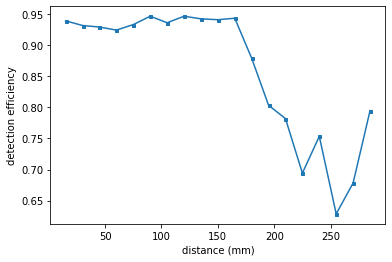

In [104]:
plt.figure()
plt.plot(bins[:-1], eff_hydr_bin,'o-', marker='s', markersize=3)
plt.xlabel('distance (mm)')
plt.ylabel('detection efficiency')
plt.show()

In [105]:
eff_hydr_bin

array([0.9392246 , 0.93179088, 0.92932038, 0.92439026, 0.93327495,
       0.94669236, 0.93624708, 0.94669236, 0.94253935, 0.94108832,
       0.94348766, 0.8791896 , 0.80341171, 0.78195906, 0.69433867,
       0.75342292, 0.62864545, 0.67841613, 0.79474707])

### Bubble shifted

In [106]:
map_bubble_sh = drum_21l_hydr_shifted.padded_histogram

In [107]:
gt_bubble_sh = np.zeros_like(map_bubble_sh)

In [108]:
gt_bubble_sh[map_bubble_sh>0] = 1

Define bin_map: same for each histogram of the same size (using padded histograms - same size as original)

In [109]:
eff_sh, eff_bubble_sh = efficiency(gt_bubble_sh, map_bubble_sh, ts, bin_map)

In [110]:
eff

0.9640622286466835

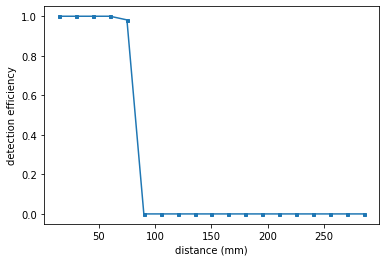

In [111]:
plt.figure()
plt.plot(bins[:-1], eff_bubble_sh,'o-', marker='s', markersize=3)
plt.xlabel('distance (mm)')
plt.ylabel('detection efficiency')
plt.show()

In [112]:
eff_bubble_sh

array([1.        , 1.        , 1.        , 1.        , 0.98155751,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])